# 2. Generating a Sample using MS1 Controller

In this notebook, we demonstrate how ViMMS can be used to generate a full-scan mzML file from a set of simulated chemicals with characteristics that resemble actual experimental data. This corresponds to Section 3.1 of the paper.

In [1]:
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('../..')

In [4]:
import os
from pathlib import Path
import pylab as plt

In [5]:
from vimms.MassSpec import IndependentMassSpectrometer
from vimms.Controller import SimpleMs1Controller
from vimms.Environment import Environment
from vimms.Common import POSITIVE, load_obj, save_obj, set_log_level_debug, set_log_level_warning
from vimms.ChemicalSamplers import DatabaseFormulaSampler, MZMLRTandIntensitySampler, MZMLChromatogramSampler, MZMLMS2Sampler
from vimms.Roi import RoiParams
from vimms.Chemicals import ChemicalMixtureCreator

Load list of extracted metabolites, created in **01. Download Data.ipynb**.

In [6]:
base_dir = os.path.abspath('example_data')
hmdb = load_obj(Path(base_dir, 'hmdb_compounds.p'))

## Create Chemicals

Define an output folder containing our results

In [7]:
out_dir = Path('results', 'MS1_single')

Here we generate the chemical objects that will be used in the sample. The chemical objects are generated by sampling from metabolites in the HMDB database.

#### Sample m/z values from the chemical formulae in HMDB

In [8]:
HMDB = os.path.join(base_dir, 'hmdb_compounds.p')
hmdb = load_obj(HMDB)

In [9]:
# create a database formula sampler that will sample from HMDB with m/z between 100 and 1000
df = DatabaseFormulaSampler(hmdb, min_mz=100, max_mz=1000)

Plot sampled m/z distribution of formulae

2022-02-25 11:10:50.585 | DEBUG    | vimms.ChemicalSamplers:sample:73 - 73822 unique formulas in filtered database
2022-02-25 11:10:50.591 | DEBUG    | vimms.ChemicalSamplers:sample:79 - Sampled formulas


(array([ 56.,  60.,  81.,  63.,  46.,  53.,  66., 155., 232., 188.]),
 array([112.0524295 , 198.79681716, 285.54120483, 372.28559249,
        459.02998015, 545.77436781, 632.51875547, 719.26314314,
        806.0075308 , 892.75191846, 979.49630612]),
 <BarContainer object of 10 artists>)

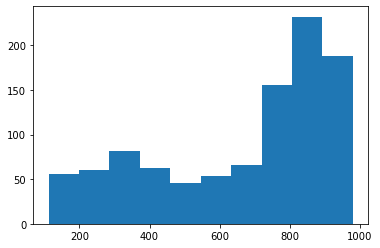

In [10]:
samples = df.sample(1000)
mz_list = [s[0].mass for s in samples]
plt.hist(mz_list)

Define the mzML file from which we'll sample various distributions for generating data, e.g. RT, intensity, chromatograms, MS2 spectra.

Here we set a very high threshold (1.75E5) on the minimum MS1 intensity of chemicals to be considered when generating various distributions. 
This is to allow the notebook to run fast. For a more accurate simulation, you should lower this to a much lower value, e.g. 1000

In [11]:
MZML = os.path.join(base_dir, 'Beer_multibeers_1_T10_POS.mzML')

In [12]:
min_ms1_intensity = 1.75E5
roi_params = RoiParams(min_intensity=min_ms1_intensity)

#### Sample RT and intensity values from an actual experimental mzML file

In [13]:
ri = MZMLRTandIntensitySampler(MZML, roi_params=roi_params)

2022-02-25 11:10:54.183 | DEBUG    | mass_spec_utils.data_import.mzml:_load_file:166 - Loaded 9423 scans


Plot sampled RT and intensity distributions

(array([946.,  30.,   9.,   5.,   2.,   2.,   2.,   2.,   1.,   1.]),
 array([ 175101.63973156, 1104320.97475573, 2033540.30977991,
        2962759.64480409, 3891978.97982826, 4821198.31485244,
        5750417.64987662, 6679636.98490079, 7608856.31992497,
        8538075.65494915, 9467294.98997332]),
 <BarContainer object of 10 artists>)

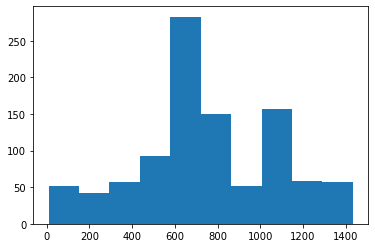

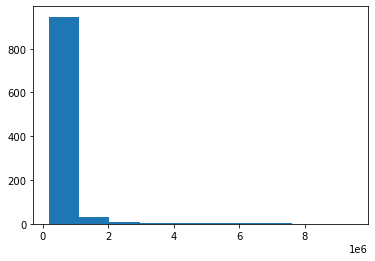

In [14]:
rt_list = []
intensity_list = []

for i in range(1000):
    a,b = ri.sample(None) #argument is a formula, but is ignored at the moment
    rt_list.append(a)
    intensity_list.append(b)

plt.figure()
plt.hist(rt_list)
plt.figure()
plt.hist(intensity_list)

#### Sample chromatograms from mzML file

In [15]:
cs = MZMLChromatogramSampler(MZML, roi_params=roi_params)

2022-02-25 11:11:19.276 | DEBUG    | vimms.ChemicalSamplers:_extract_rois:370 - Extracted 25281 good ROIs from /Users/joewandy/Work/git/vimms/examples/01. vimms (Wandy et al 2019)/example_data/Beer_multibeers_1_T10_POS.mzML


#### Sample MS2 spectra from mzML file

In [16]:
ms = MZMLMS2Sampler(MZML)

2022-02-25 11:11:22.780 | DEBUG    | mass_spec_utils.data_import.mzml:_load_file:166 - Loaded 9423 scans
2022-02-25 11:11:22.976 | DEBUG    | vimms.ChemicalSamplers:_filter_scans:607 - 7672 MS2 scansn remaining


## Put everything together

In [17]:
cm = ChemicalMixtureCreator(df, rt_and_intensity_sampler=ri, chromatogram_sampler=cs, ms2_sampler=ms)
dataset = cm.sample(6500, 2)

2022-02-25 11:11:26.589 | DEBUG    | vimms.ChemicalSamplers:sample:73 - 73822 unique formulas in filtered database
2022-02-25 11:11:26.600 | DEBUG    | vimms.ChemicalSamplers:sample:79 - Sampled formulas
2022-02-25 11:11:27.455 | DEBUG    | vimms.Chemicals:sample:324 - Sampled rt and intensity values and chromatograms


In [18]:
save_obj(dataset, Path(out_dir, 'dataset.p'))

2022-02-25 11:11:36.026 | INFO     | vimms.Common:create_if_not_exist:309 - Created results/MS1_single
2022-02-25 11:11:36.027 | INFO     | vimms.Common:save_obj:329 - Saving <class 'list'> to results/MS1_single/dataset.p


In [19]:
for chem in dataset[0:10]:
    print(chem)

KnownChemical - 'C23H30N2O4' rt=803.55 max_intensity=184044.81
KnownChemical - 'C55H104O6' rt=408.34 max_intensity=252663.54
KnownChemical - 'C39H76O5' rt=789.07 max_intensity=302142.27
KnownChemical - 'C11H21N3O5' rt=1029.22 max_intensity=498034.28
KnownChemical - 'C61H98O6' rt=932.93 max_intensity=216095.92
KnownChemical - 'C34H64O6' rt=679.99 max_intensity=176165.85
KnownChemical - 'C18H20O5' rt=507.17 max_intensity=225181.60
KnownChemical - 'C63H100O6' rt=646.59 max_intensity=197727.49
KnownChemical - 'C56H108O6' rt=715.94 max_intensity=243945.03
KnownChemical - 'C6H11O10P' rt=968.44 max_intensity=181157.42


## Run MS1 controller on the samples and generate .mzML files

In [20]:
set_log_level_warning()

1

In [21]:
rt_range = [(0, 1440)]
min_rt = rt_range[0][0]
max_rt = rt_range[0][1]

In [22]:
# set the log level to WARNING so we don't see too many messages when environment is running
set_log_level_warning()

2

In [23]:
mass_spec = IndependentMassSpectrometer(POSITIVE, dataset)
controller = SimpleMs1Controller()

In [24]:
# create an environment to run both the mass spec and controller
env = Environment(mass_spec, controller, min_rt, max_rt, progress_bar=True)

# run the simulation
env.run()

  0%|          | 0/1440 [00:00<?, ?it/s]

Simulated results are saved to the following .mzML file and can be viewed in tools like [ToppView](https://pubs.acs.org/doi/abs/10.1021/pr900171m) or using other mzML file viewers.

In [25]:
mzml_filename = 'ms1_controller.mzML'
env.write_mzML(out_dir, mzml_filename)